In [ ]:
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=9c8ed4e877036975039fe9e513aa07bd386d88b0d4afaef9e5c4ddcc748ae33b
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


Proszę zaprojektować rozmyty system sterowania automatycznym podlewaniem grządki. Grządka ma 3m^2, a system podlewania może nawadniać w tempie maksymalnie 25l/dziennie, podczas, gdy zalecana ilość wody dla "zwyczajnych" warunków dla grządki w takim rozmiarze to 10l/dziennie.

schematics.png

System jest sterowany elektronicznie i jest do niego podłączony higrometr (mierzący wilgotność względną w zakresie od 0% do 100%) i termometr. Temperatury są mierzone wyłącznie za dnia i znajdują się w zakresie 15°C - 35°C.Proszę zaprojektować układ rozmytego sterowania, układając reguły na podstawie następującej tabelki:
	Sucho 	Przeciętnie 	Mokro
Chłodno 	Podlewaj średnio 	Podlewaj średnio 	Podlewaj mało
Ciepło 	Podlewaj dużo 	Podlewaj średnio 	Podlewaj mało
Gorąco 	Podlewaj dużo 	Podlewaj dużo 	Podlewaj średnio

Proszę samodzielnie zaproponować rozmyte funkcje przynależności i narysować je na wykresach. Proszę przedstawić heatmapę wynikowej funkcji ilości wody używanej dziennie w zależności od wilgotności i temperatury ukrytej w mechanizmie sterowania.

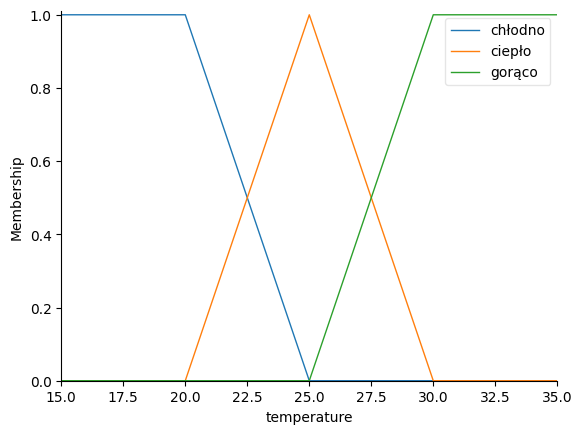

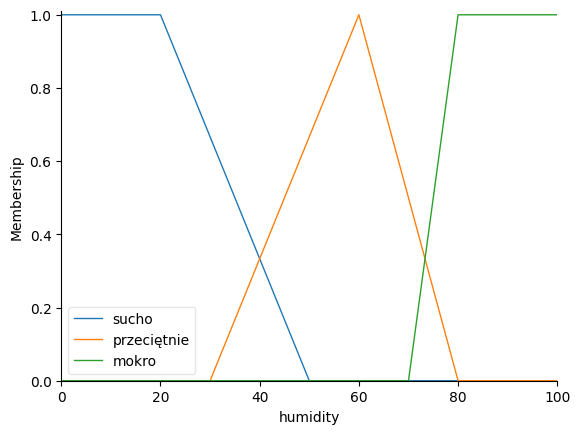

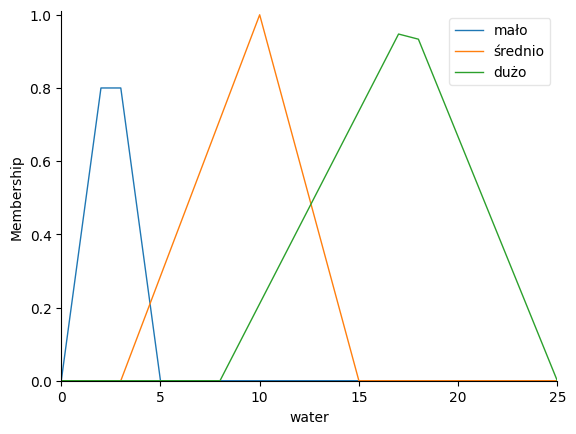

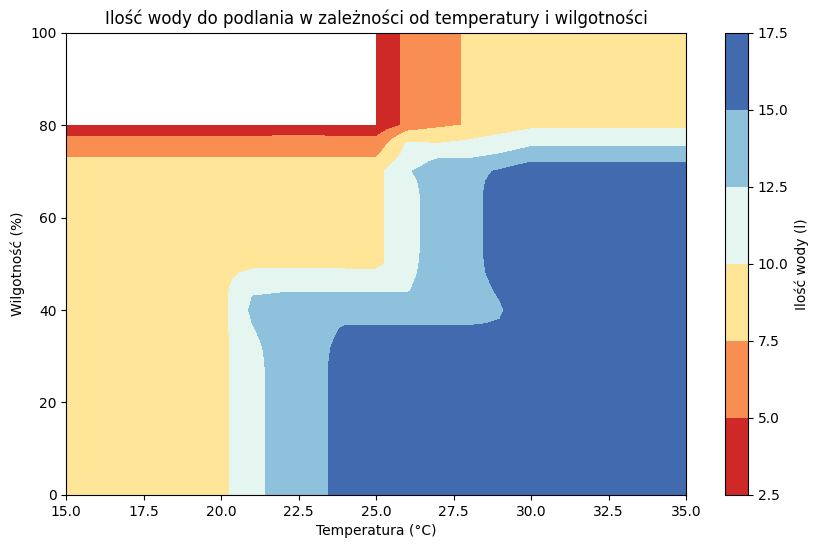

In [ ]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl


temperature_range = (15, 35)
humidity_range = (0, 100)
water_range = (0, 25)


temperature = ctrl.Antecedent(np.arange(15, 36, 1), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')
water = ctrl.Consequent(np.arange(0, 26, 1), 'water')



temperature['chłodno'] = fuzz.trapmf(temperature.universe, [15, 15, 20, 25])
temperature['ciepło'] = fuzz.trimf(temperature.universe, [20, 25, 30])
temperature['gorąco'] = fuzz.trapmf(temperature.universe, [25, 30, 35, 35])

temperature.view()

humidity['sucho'] = fuzz.trapmf(humidity.universe, [0, 0, 20, 50])
humidity['przeciętnie'] = fuzz.trimf(humidity.universe, [30, 60, 80])
humidity['mokro'] = fuzz.trapmf(humidity.universe, [70, 80, 100, 100])

humidity.view()

water['mało'] = fuzz.trimf(water.universe, [0, 2.5, 5])
water['średnio'] = fuzz.trimf(water.universe, [3, 10, 15])
water['dużo'] = fuzz.trimf(water.universe, [8, 17.5, 25])

water.view()

rule1=ctrl.Rule(antecedent=((humidity['sucho'] & temperature['chłodno']) | (humidity['przeciętnie'] & temperature['chłodno']) | (humidity['przeciętnie'] & temperature['ciepło']) | (humidity['mokro'] & temperature['gorąco'])), consequent=water['średnio'], label='rule średnio')
rule2=ctrl.Rule(antecedent=((humidity['sucho'] & temperature['ciepło']) | (humidity['sucho'] & temperature['gorąco']) | (humidity['przeciętnie'] & temperature['gorąco'])), consequent=water['dużo'], label='rule dużo')
rule3=ctrl.Rule(antecedent=((humidity['mokro'] & temperature['ciepło']) | humidity['mokro'] & temperature['chłodno']), consequent=water['mało'], label='rule mało')

watering_ctrl=ctrl.ControlSystem([rule1, rule2, rule3])
watering=ctrl.ControlSystemSimulation(watering_ctrl)

temp_values=np.arange(15,36,1)
hum_values=np.arange(0,101,1)
water_output = np.zeros((len(hum_values), len(temp_values)))

for i, temp in enumerate(temp_values):
  for j, hum in enumerate(hum_values):
    watering.input['temperature']=temp
    watering.input['humidity']=hum
    watering.compute()
    water_output[j,i]=watering.output['water']


plt.figure(figsize=(10, 6))
plt.contourf(temp_values, hum_values, water_output, 5, cmap='RdYlBu')
plt.colorbar(label='Ilość wody (l)')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Wilgotność (%)')
plt.title('Ilość wody do podlania w zależności od temperatury i wilgotności')
plt.show()

Proszę zastanowić się, jaką dodatkową zmienną można wprowadzić do systemu, np. oczekiwany poziom deszczu następnego dnia, wilgotność gleby, nasłonecznienie, siłę wiatru, itp. Problem jest praktyczny, więc proszę zastanowić się przede wszystkim nad takimi zmiennymi, które da się zmierzyć używając elektroniki lub pobrać z jakiegoś internetowego API (np. pogodowego). Proszę ustalić dla tej zmiennej jednostkę, zaproponować jej przynależność do zbiorów rozmytych oraz reguły wnioskowania. Proszę przedstawić co najmniej 4 heatmapy zależności nawadniania od temperatury i wilgotności dla 4 wartości zaproponowanej przez państwa zmiennej. Proszę też podać, jakim czujnikiem lub z jakiego API można pobrać te dane.

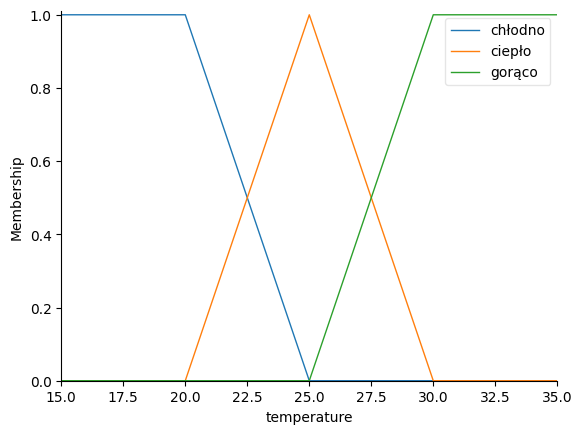

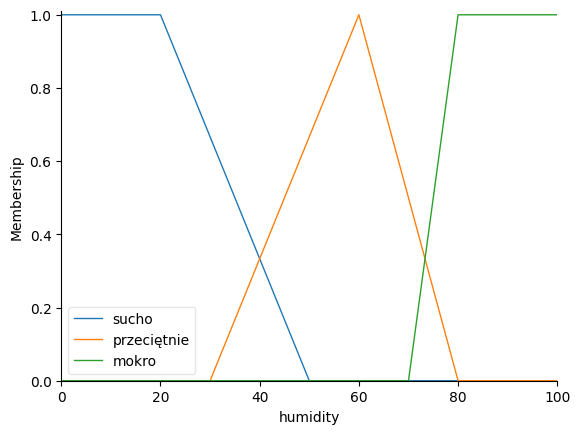

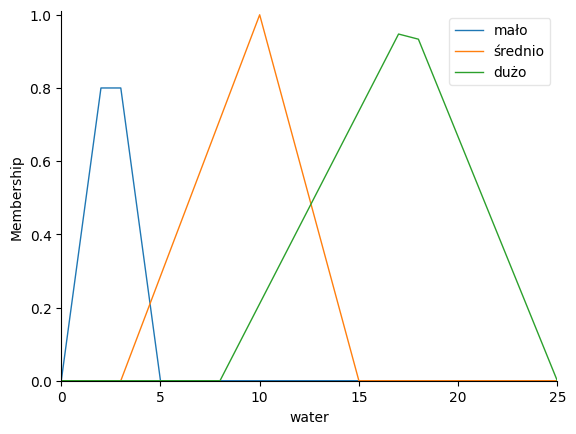

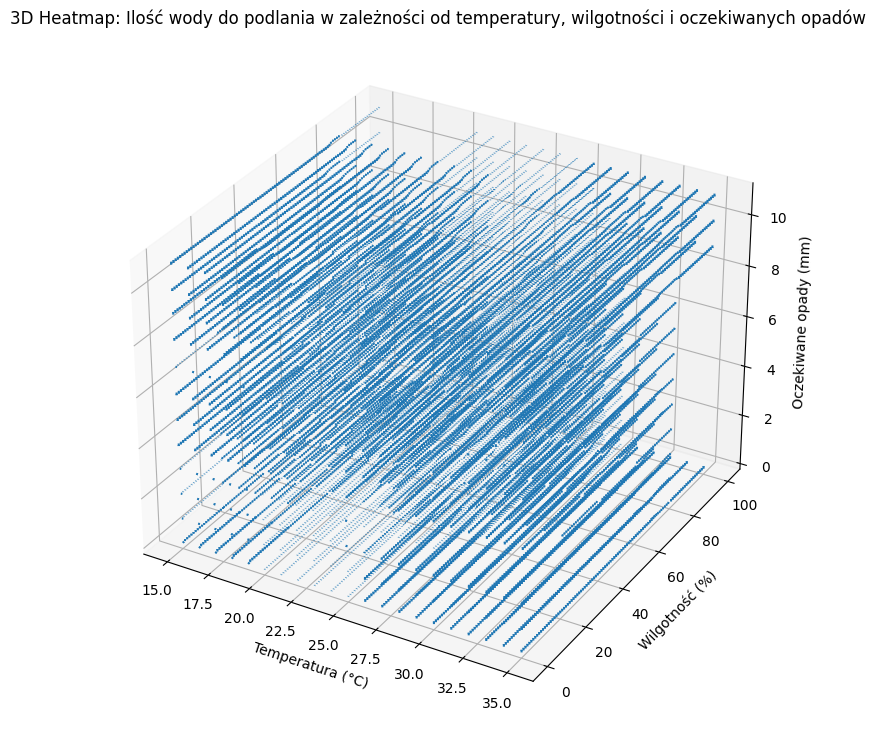

In [ ]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
from mpl_toolkits.mplot3d import Axes3D


temperature_range = (15, 35)
humidity_range = (0, 100)
water_range = (0, 25)


temperature = ctrl.Antecedent(np.arange(15, 36, 1), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')
water = ctrl.Consequent(np.arange(0, 26, 1), 'water')
expected_rainfall_levels=ctrl.Antecedent(np.arange(0,13,1), 'expected rainfall levels')
#dodatkowy parametr to będzie oczekiwany poziom opadów. Jego jednostka to mm słupka rtęci. Dane pogodowe można sfetchować z poniższego API: https://openweathermap.org/api


expected_rainfall_levels['brak opadów']=fuzz.trimf(expected_rainfall_levels.universe, [0,2,2])
expected_rainfall_levels['lekkie opady']=fuzz.trimf(expected_rainfall_levels.universe, [1,3,5])
expected_rainfall_levels['umiarkowane opady']=fuzz.trimf(expected_rainfall_levels.universe, [4,7,10])
expected_rainfall_levels['silne opady']=fuzz.trimf(expected_rainfall_levels.universe, [9,12,12])

temperature['chłodno'] = fuzz.trapmf(temperature.universe, [15, 15, 20, 25])
temperature['ciepło'] = fuzz.trimf(temperature.universe, [20, 25, 30])
temperature['gorąco'] = fuzz.trapmf(temperature.universe, [25, 30, 35, 35])

temperature.view()

humidity['sucho'] = fuzz.trapmf(humidity.universe, [0, 0, 20, 50])
humidity['przeciętnie'] = fuzz.trimf(humidity.universe, [30, 60, 80])
humidity['mokro'] = fuzz.trapmf(humidity.universe, [70, 80, 100, 100])

humidity.view()

water['mało'] = fuzz.trimf(water.universe, [0, 2.5, 5])
water['średnio'] = fuzz.trimf(water.universe, [3, 10, 15])
water['dużo'] = fuzz.trimf(water.universe, [8, 17.5, 25])

water.view()


rule1=ctrl.Rule(antecedent=((humidity['sucho'] & temperature['chłodno']) | (humidity['przeciętnie'] & temperature['chłodno']) | (humidity['przeciętnie'] & temperature['ciepło']) | (humidity['mokro'] & temperature['gorąco'])), consequent=water['średnio'], label='rule średnio')
rule2=ctrl.Rule(antecedent=((humidity['sucho'] & temperature['ciepło']) | (humidity['sucho'] & temperature['gorąco']) | (humidity['przeciętnie'] & temperature['gorąco'])), consequent=water['dużo'], label='rule dużo')
rule3=ctrl.Rule(antecedent=((humidity['mokro'] & temperature['ciepło']) | humidity['mokro'] & temperature['chłodno']), consequent=water['mało'], label='rule mało')
rule4 = ctrl.Rule(antecedent=expected_rainfall_levels['silne opady'],
                  consequent=water['mało'], label='rule bardzo mało z powodu silnych opadów')
rule5 = ctrl.Rule(antecedent=((expected_rainfall_levels['umiarkowane opady'] & humidity['sucho'])),
                  consequent=water['mało'], label='rule mało z powodu umiarkowanych opadów i suchości')
rule6 = ctrl.Rule(antecedent=((expected_rainfall_levels['lekkie opady'] & temperature['gorąco'])),
                  consequent=water['średnio'], label='rule średnio z powodu lekkich opadów i gorąca')
rule7 = ctrl.Rule(antecedent=((expected_rainfall_levels['brak opadów'] & temperature['gorąco'] & humidity['sucho'])),
                  consequent=water['dużo'], label='rule dużo bez opadów, przy gorącu i suchości')

watering_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])
watering = ctrl.ControlSystemSimulation(watering_ctrl)

expected_rainfall_levels=np.arange(0,12,1)
temp_values=np.arange(15,36,1)
hum_values=np.arange(0,101,1)
water_output = np.zeros((len(hum_values), len(temp_values), len(expected_rainfall_levels)))

for i, temp in enumerate(temp_values):
  for j, hum in enumerate(hum_values):
    for k, exp_rain_lev in enumerate(expected_rainfall_levels):
      watering.input['temperature']=temp
      watering.input['humidity']=hum
      watering.input['expected rainfall levels']=exp_rain_lev
      watering.compute()
      water_output[j,i,k]=watering.output['water']


fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

X, Y, Z = np.meshgrid(temp_values, hum_values, expected_rainfall_levels)
U, V, W = np.gradient(water_output, edge_order=2)

ax.quiver(X, Y, Z, U, V, W, length=0.1, normalize=True)

ax.set_xlabel('Temperatura (°C)')
ax.set_ylabel('Wilgotność (%)')
ax.set_zlabel('Oczekiwane opady (mm)')
plt.title('3D Heatmap: Ilość wody do podlania w zależności od temperatury, wilgotności i oczekiwanych opadów')
plt.show()




Analizując heatmapy przedstawione w dokumentach dotyczących systemu podlewania, można wyciągnąć kilka wniosków odnośnie ich zachowania i skuteczności w kontekście dostosowania ilości wody do warunków otoczenia:

1 - Gradacja kolorów i przejścia: Heatmapy wykazują wyraźne gradacje kolorów, które reprezentują różne poziomy podlewania (mało, średnio, dużo). Te gradacje są dobrze zdefiniowane i zrozumiałe, co świadczy o skutecznym użyciu funkcji przynależności w systemie rozmytym.

2 - Reakcja na zmienne: Heatmapy wyraźnie pokazują, jak system reaguje na zmiany w dwóch głównych zmiennych — temperaturze i wilgotności. Na przykład, zwiększenie temperatury lub zmniejszenie wilgotności prowadzi do zwiększenia ilości wody

3 - Znaczenie dodatkowych zmiennych: Dodanie zmiennej, jaką jest oczekiwany poziom opadów, wprowadza dodatkową głębię w analizę i pozwala na lepsze dostosowanie ilości podlewania.

4 - Odpowiedniość reakcji systemu: Generalnie, heatmapy sugerują, że system zachowuje się odpowiednio do danych wejściowych.

 Te dwa zadania pokazują, jak zaawansowane techniki, takie jak logika rozmyta, mogą być wykorzystane do tworzenia inteligentnych systemów automatycznego podlewania, które są elastyczne, efektywne i mogą być dostosowane do specyficznych potrzeb i warunków środowiskowych.